In [1]:
import pandas as pd
import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, optimizers, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix


In [4]:
# Here we create a dict which consists label for each image path and its particular data.
def load_file(file_path, label):

    # declare the folder name
    folder_name = file_path.split("/")[-1]
    # declare output list
    out_list = []
    # load every file that .png format
    for image_path in glob.glob(file_path + "/*.*"):
        # read image file
        # image = imageio.imread(image_path)
        image = imageio.v2.imread(image_path)   
        # print(image_path)
        # declare temporary dict dtype
        temp = {}
        # set the file name
        temp["name"] = image_path.split("/")[-1]
        # set the file label, 0 for non defect. 1 for defect
        temp["label"] = label

        # There are somes images are tensor dtype
        # Thus I fix by selecting only a tensor index zero
        try:   
            temp["data"] = image[:,:,0].astype("int") 
        except:
            # normal case
            temp["data"] = image.astype("int")
        # append temp into output list
        out_list.append(temp)
    # print process status by checking size of output list
    if len(out_list) == 0:
        print("loading files from folder: {} is failed".format(folder_name))
    else:
        print("loading file from folder: {} is successful".format(folder_name))
    # convert list into numpy array dtype
    return np.array(out_list)

In [5]:
acnitic_images_path      =  r"C:\Users\lenovo\Downloads\skin canser\augmented_new_data\A"
derma_images_path =  r"C:\Users\lenovo\Downloads\skin canser\augmented_new_data\D"
vascular_images_path =  r"C:\Users\lenovo\Downloads\skin canser\augmented_new_data\V"

In [6]:
acnitic_images_path = load_file(file_path=acnitic_images_path, label=0)
derma_images_path = load_file(file_path=derma_images_path, label=1)
vascular_images_path = load_file(file_path=vascular_images_path, label=2)

loading file from folder: C:\Users\lenovo\Downloads\skin canser\augmented_new_data\A is successful
loading file from folder: C:\Users\lenovo\Downloads\skin canser\augmented_new_data\D is successful
loading file from folder: C:\Users\lenovo\Downloads\skin canser\augmented_new_data\V is successful


In [7]:
acnitic_images_path.shape

(1186,)

In [8]:
derma_images_path.shape

(1171,)

In [9]:
vascular_images_path.shape

(1307,)

## **Prepare and clean the data to avoid error during model fitting.**

---



---



In [10]:
np.random.shuffle(acnitic_images_path)
np.random.shuffle(derma_images_path)
np.random.shuffle(vascular_images_path)

# the class size is the min length compared with defect-free and defect images, we do this in orde to balance the dataset.
if (acnitic_images_path.shape[0] <= derma_images_path.shape[0]) and (acnitic_images_path.shape[0] <= vascular_images_path.shape[0]):
  class_size = acnitic_images_path.shape[0]
elif (derma_images_path.shape[0] <= vascular_images_path.shape[0]) and (derma_images_path.shape[0] <= acnitic_images_path.shape[0]):
  class_size = derma_images_path.shape[0]
else:
  class_size = vascular_images_path.shape[0]
print("Class Size:", class_size)


Class Size: 1171


In [11]:
# we shuffle the order of defect-free and defect images
np.random.shuffle(acnitic_images_path)
np.random.shuffle(derma_images_path)
np.random.shuffle(vascular_images_path)

# Concatenate both the datasets with size as class_size.
dataset = np.concatenate((acnitic_images_path[:class_size], derma_images_path[:class_size], vascular_images_path[:class_size]))

# create an empty matrix X of 256x4096 and has dataset length row, which holds all the data i.e images from dataset.
# Independent Features -> X
X = np.empty([dataset.shape[0], 180, 180]).astype(int)

# create vector y which has dataset length, which holds all the labels for our data, this is jsut similar to partitioning the data before splitting, 
# Target_variable -> y
y = np.empty(dataset.shape[0]).astype(int)

# assign the X,y one-by-one
for i in range(dataset.shape[0]):
    X[i] = dataset[i]["data"]
    y[i] = dataset[i]["label"]

# since Keras acquire the Image input in a tensor type -> we reshape X
X = X.reshape(X.shape[0], 180, 180, 1)
print(X.shape)

# display size of the label 0 and label 1 
np.unique(y, return_counts=True)


(3513, 180, 180, 1)


(array([0, 1, 2]), array([1171, 1171, 1171], dtype=int64))

## **Model Building**

In [12]:
def create_model(image_shape = (180, 180, 1), print_summary = True):
    model = models.Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 1)))
    model.add(layers.Conv2D(16, 3, padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(32, 3, padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(64, 3, padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.20))

    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(3, activation = 'sigmoid'))

    
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    
    # show the CNN model detail
    if print_summary:
        model.summary()
    return model

def train_model(model, xtrain, ytrain, xval, yval, n_epoch, batch_size):
    # train CNN model
    # batch size to reduce memory usage
    # set early stopping to avoid overfitting
    
    earlystopping = EarlyStopping(monitor='accuracy', patience=2)
    filepath = "C:/Users/heman/Downloads/Capstone_Project/SKIN/models/different_class_accuracy/weights-best-{epoch:02d}-{accuracy:.2f}-{val_accuracy:.2f}.hdf5"
    
    checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, earlystopping]

    history = model.fit(xtrain, ytrain, epochs=n_epoch, batch_size=batch_size, validation_data=(xval, yval), callbacks=[callbacks_list])
    return history


create_model(image_shape=(180, 180, 1), print_summary=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      160       
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 90, 90, 32)        0         
                                                        

## Train and Export CNN Model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=23)
print("y_train: number of samples each class: {}".format(np.unique(y_train, return_counts=True)))
print("y_test: number of samples each class: {}".format(np.unique(y_test, return_counts=True)))

y_train: number of samples each class: (array([0, 1, 2]), array([1054, 1050, 1057], dtype=int64))
y_test: number of samples each class: (array([0, 1, 2]), array([117, 121, 114], dtype=int64))


In [14]:
cnn_model = None
cnn_model = create_model(image_shape=(180, 180, 1))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      160       
                                                                 
 activation_4 (Activation)   (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 activation_5 (Activation)   (None, 90, 90, 32)        0         
                                                      

In [ ]:
earlystopping = EarlyStopping(monitor='accuracy', patience=5)
filepath = "C:/Users/heman/Downloads/Capstone_Project/SKIN/models/different_class_accuracy/weights-best-{epoch:02d}-{accuracy:.2f}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, earlystopping]

In [ ]:
# No need to run this, if you are loading the model, if not you cna run this to train your model again and save another weights file.
cnn_model.fit(X_train, y_train, batch_size=10, epochs=20, validation_split=0.1, callbacks=callbacks_list) 

Epoch 1/30


C:\Users\heman\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


282/282 [==============================] - ETA: 0s - loss: 1.0788 - accuracy: 0.3674
Epoch 1: accuracy improved from -inf to 0.36738, saving model to C:/Users/heman/Downloads/Capstone_Project/SKIN/models/different_class_accuracy\weights-best-01-0.37-0.38.hdf5
282/282 [==============================] - 70s 236ms/step - loss: 1.0788 - accuracy: 0.3674 - val_loss: 1.0631 - val_accuracy: 0.3790
Epoch 2/30
282/282 [==============================] - ETA: 0s - loss: 1.0267 - accuracy: 0.4135
Epoch 2: accuracy improved from 0.36738 to 0.41348, saving model to C:/Users/heman/Downloads/Capstone_Project/SKIN/models/different_class_accuracy\weights-best-02-0.41-0.41.hdf5
282/282 [==============================] - 66s 235ms/step - loss: 1.0267 - accuracy: 0.4135 - val_loss: 1.0369 - val_accuracy: 0.4076
Epoch 3/30
282/282 [==============================] - ETA: 0s - loss: 0.9963 - accuracy: 0.4401
Epoch 3: accuracy improved from 0.41348 to 0.44007, saving model to C:/Users/heman/Downloads/Capstone_

In [ ]:
score, acc = cnn_model.evaluate(X_test, y_test, verbose=0)
score, acc

(2.25661563873291, 0.6590257883071899)

In [ ]:
# Starting the training where we have stopped.
# cnn_model.fit(X_train, y_train, batch_size=10, initial_epochs=10, validation_split=0.1, callbacks=callbacks_list)

In [ ]:
# load the saved model
from tensorflow.keras.models import load_model
loaded_model = load_model('C:/Users/heman/Downloads/Capstone_Project/SKIN/models/weights-best-04-0.91-0.73.hdf5')

In [ ]:
score, acc = loaded_model.evaluate(X_test, y_test, verbose=0)
score, acc

(0.4080801010131836, 0.8767908215522766)

In [ ]:
# No need to run this, if you are loading the model, if not you cna run this to train your model again and save another weights file.
loaded_model.fit(X_train, y_train, batch_size=10, epochs=30, validation_split=0.1, callbacks=callbacks_list) 

Epoch 1/30
282/282 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.8433
Epoch 1: accuracy did not improve from 0.99787
282/282 [==============================] - 64s 224ms/step - loss: 0.4727 - accuracy: 0.8433 - val_loss: 0.5704 - val_accuracy: 0.7771
Epoch 2/30
282/282 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.9004
Epoch 2: accuracy did not improve from 0.99787
282/282 [==============================] - 62s 221ms/step - loss: 0.2866 - accuracy: 0.9004 - val_loss: 0.3835 - val_accuracy: 0.8758
Epoch 3/30
282/282 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9245
Epoch 3: accuracy did not improve from 0.99787
282/282 [==============================] - 62s 221ms/step - loss: 0.2075 - accuracy: 0.9245 - val_loss: 0.4105 - val_accuracy: 0.8790
Epoch 4/30
282/282 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9397
Epoch 4: accuracy did not improve from 0.99787
282/282 [=================

In [ ]:
score, acc = loaded_model.evaluate(X_test, y_test, verbose=0)
score, acc

(0.8856669664382935, 0.8051576018333435)

In [ ]:
# load the saved model
from tensorflow.keras.models import load_model
loaded_model_2 = load_model('C:/Users/heman/Downloads/Capstone_Project/SKIN/models/weights-best-04-0.91-0.73.hdf5')

In [ ]:
score, acc = loaded_model_2.evaluate(X_test, y_test, verbose=0)
score, acc

(0.4080801010131836, 0.8767908215522766)

In [ ]:
# No need to run this, if you are loading the model, if not you cna run this to train your model again and save another weights file.
loaded_model_2.fit(X_train, y_train, batch_size=10, epochs=30, validation_split=0.1, callbacks=callbacks_list) 

Epoch 1/30
282/282 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.8489
Epoch 1: accuracy did not improve from 0.99929
282/282 [==============================] - 53s 187ms/step - loss: 0.4491 - accuracy: 0.8489 - val_loss: 0.3927 - val_accuracy: 0.8599
Epoch 2/30
282/282 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.9067
Epoch 2: accuracy did not improve from 0.99929
282/282 [==============================] - 61s 216ms/step - loss: 0.2740 - accuracy: 0.9067 - val_loss: 0.3942 - val_accuracy: 0.8694
Epoch 3/30
282/282 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9298
Epoch 3: accuracy did not improve from 0.99929
282/282 [==============================] - 51s 180ms/step - loss: 0.2025 - accuracy: 0.9298 - val_loss: 0.4342 - val_accuracy: 0.8662
Epoch 4/30
282/282 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9450
Epoch 4: accuracy did not improve from 0.99929
282/282 [=================

In [94]:
# load the saved model
from tensorflow.keras.models import load_model
loaded_model_3 = load_model(r'C:\Users\lenovo\Downloads\skin canser\models\different_class_accuracy\weights-best-27-0.99-0.70.hdf5')

In [95]:
score, acc = loaded_model_3.evaluate(X_test, y_test, verbose=0)
score, acc

C:\Users\lenovo\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


(0.4953608512878418, 0.9289772510528564)

In [96]:
y_pred = loaded_model_3.predict(X_test)

11/11 [==============================] - 3s 222ms/step


In [97]:
y_pred

array([[8.1927471e-02, 9.5828891e-01, 8.9345060e-02],
       [9.9920183e-01, 2.3273264e-01, 1.2337971e-01],
       [9.7983146e-01, 3.7659678e-01, 3.0868778e-01],
       ...,
       [2.7623248e-05, 9.3918240e-01, 9.9066138e-01],
       [1.0000000e+00, 2.4566036e-03, 2.7020883e-10],
       [9.7267836e-01, 9.4421387e-01, 1.0287554e-02]], dtype=float32)

In [98]:
len(y_pred)

352

In [99]:
count = len(y_pred)
result = []
for i in range(count):
    if np.argmax(y_pred[i]) == 0:
        result.append(0)
    elif np.argmax(y_pred[i]) == 1:
        result.append(1)
    else:
        result.append(2)

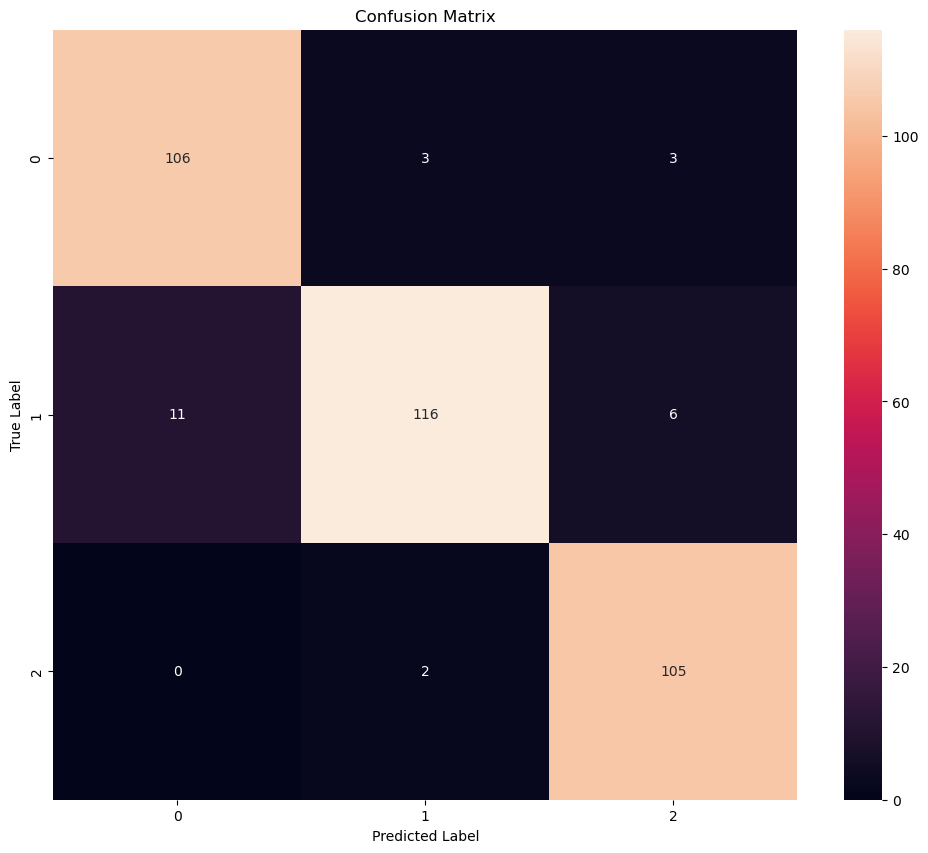

In [100]:
plt.figure(figsize = (12,10))
cf_matrix = confusion_matrix(result,y_test)
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### Testing on Single Image

In [104]:
# y_test[34] # 2

# y_test[54] # 2

y_test[89] # 0


#y_test[54] # 0

1

In [106]:
xi = np.array(X_test[89]).reshape(-1, 180, 180, 1)
print(xi.shape)

(1, 180, 180, 1)


In [107]:
prediction = loaded_model_3.predict(xi)
# np.argmax(prediction)
if np.argmax(prediction) == 0:
    print("THe Person is Having Acnitic Keratosis")
elif np.argmax(prediction) == 1:
    print("The Person is Having Dermatofibroma")
else:
    print("The Person is Having Vascular Lesion")

1/1 [==============================] - 0s 168ms/step
The Person is Having Dermatofibroma


In [112]:
import cv2
import tensorflow
from tensorflow import keras
import warnings
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model

def run(source=None):

    model = tensorflow.keras.models.load_model(r'C:\Users\lenovo\Downloads\skin canser\models\different_class_accuracy\weights-best-27-0.99-0.70.hdf5')

    img = cv2.imread(source)

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(img_gray, (5, 5), 0)   
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    img_half = cv2.resize(img, (180, 180))
    img_half = cv2.cvtColor(img_half, cv2.COLOR_BGR2GRAY)
    x = img_to_array(img_half)
    x = np.array(x).reshape(-1, 180, 180, 1)
    prediction = model.predict(x)
    if np.argmax(prediction) == 0:
        # print("Dont worry your Knee was very safe, take healthy food ")
        return 'Acnitic Keratosis'
    elif np.argmax(prediction) == 1:
        # print("The Fabric is Good. ")
        return 'Dermatofibroma'
    elif np.argmax(prediction) == 2:
        # print("The Fabric is Good. ")
        return 'Vascular Lesion'
    
        



In [114]:
run(source=r"C:\Users\lenovo\Downloads\skin canser\resized_new_classes-20230302T065126Z-001\resized_new_classes\D\images0.jpg")

1/1 [==============================] - 0s 148ms/step


'Dermatofibroma'

In [117]:
!pip install streamlit

     ---------------------------------------- 9.6/9.6 MB 12.3 MB/s eta 0:00:00
     ------------------------------------- 164.8/164.8 kB 10.3 MB/s eta 0:00:00
     --------------------------------------- 20.6/20.6 MB 10.6 MB/s eta 0:00:00
     ---------------------------------------- 4.7/4.7 MB 13.6 MB/s eta 0:00:00
     ------------------------------------- 813.6/813.6 kB 12.8 MB/s eta 0:00:00
     ------------------------------------- 239.0/239.0 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 184.3/184.3 kB 10.9 MB/s eta 0:00:00
     ---------------------------------------- 62.7/62.7 kB ? eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 10.2 MB/s eta 0:00:00
     ---------------------------------------- 84.5/84.5 kB 4.9 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=7f1c9d9ff0d17a

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.2.2 requires pyqt5<5.13, which is not installed.
spyder 5.2.2 requires pyqtwebengine<5.13, which is not installed.


In [118]:
! python abc.py



1/1 [==============================] - 1s 872ms/step
C:\Users\lenovo\Downloads\skin canser\augmented_new_data\D\image_0_9871.jpg


2023-03-02 13:31:06.660938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 13:31:13.274 
  command:

    streamlit run abc.py [ARGUMENTS]


In [119]:
! streamlit run abc.py


^C


In [122]:
from sklearn.metrics import classification_report
print(classification_report(y_test, result))
# print(f"Precision Score of the classifier is: {confusion_matrix(y_test, result)}")

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       117
           1       0.87      0.96      0.91       121
           2       0.98      0.92      0.95       114

    accuracy                           0.93       352
   macro avg       0.93      0.93      0.93       352
weighted avg       0.93      0.93      0.93       352

